# Project

In [123]:
#  imports and set magics
import numpy as np
import pandas as pd
import json
import tqdm
import time
import datetime
import os
import requests
from bs4 import BeautifulSoup
import re
import pyarrow

# Project

**Authors:** 
* Jørgen Baun Høst, pjz633@alumni.ku.dk
* Marius Heltberg Lassen, pgb206@alumni.ku.dk

This notebook contains the data extraction, data structuring and manipulation, calculations and figures for our project *Liar, liar, pants on fire? Fake news detection with supervised machine learning*.

Dependencies:

In [124]:
# %pip install

## Web scraping 

### Define functions:

General functions:

In [125]:
def log(response: requests.Response):
    """
    Creates or appends a log-file with information from a `requests.get()`-call.
    
    The information gathered is:
    - - - - - - - -
        timestamp   :   Current local time.
        status_code :   Status code from requests call.
        length      :   Length of the HTML-string.
        output_path :   Current working directory.
        url         :   The URL of the response.
    """

    # Open or create the csv file
    if os.path.isfile('log'):
        log = open('log','a')
    else: 
        log = open('log','w')
        header = ['timestamp', 'status_code', 'length', 'output_file', 'url'] # Header names
        log.write(';'.join(header) + "\n")
        
    # Gather log information
    status_code = response.status_code # Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) # Local time
    length = len(response.text) # Length of the HTML-string
    output_path = os.getcwd() # Output path
    url = response.url # URL-string
    
    # Open the log file and append the gathered log information
    with open('log','a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path};{url}' + "\n") 


def get_soup(url: str, header: dict) -> BeautifulSoup:
    """
    Constructs a HTML-string from a request of the given URL. 
    Requests are logged, see `log()`. 

    Input:
    - - - - - - - - 
    url (str)     :    URL of the website to receive the HTML-string from. \n
    header (dict) :    Dictionary to send in the query string for the request.

    Returns:
    - - - - - - - - 
    soup (BeautifulSoup) :  HTML-string in the class of BeutifulSoup with 'lxml' parser.
    """

    response = requests.get(url, headers=header) # Request
    log(response) # Log 
    soup = BeautifulSoup(response.content, 'lxml') # Convert to response to HTML

    return soup


def extract_articles_pf_pages(soup: BeautifulSoup) -> list:
    """
    Extracts articles from HTML-string from the PolitiFact website.

    Input:
    - - - - - - - -
    soup (BeautifulSoup) : HTML-string from the PolitiFact website.

    Returns:
    - - - - - - - - 
    list_of_articles (list) : A list of all articles in the given soup. \n
                              Each element is an article of data structure as BeautifulSoup.
    """
    
    articles = soup.find(class_='o-listicle__list') # Find section with articles
    list_of_articles = articles.find_all('li') # Find all articles as a list

    return list_of_articles

PolitiFact functions:

In [126]:
def create_url_pf_pages(page: int) -> str:
    """
    Creates a PolitiFact URL with the given pagenumber.

    Input:
    - - - - - - - -
    page (int) :    Pagenumber for the PolitiFact website.

    Returns:
    - - - - - - - -
    url (str)  :    URL of the PolitiFact website for given page. 
    """

    url = f'https://www.politifact.com/factchecks/list/?page={page}' # Construct url with f-string

    return url


def extract_info_pf_pages(article: BeautifulSoup) -> list:
    """
    Extracts all relevant information from one article on the article overview pages on the PolitiFact website.

    Input:
    - - - - - - - - 
    article (BeautifulSoup) :  Article to extract data from, see `extract_articles()`.

    Returns:
    - - - - - - - - 
    [name_txt, name_href, description_txt, quote_txt, quote_href, meter, footer] (list) \n 
    The name and URL of the quoted person, the description of the quote, the quote itself \n
    and link hereof, the truthfulness index, and information on the article in string-format.
    """

    # Statement name 
    name = article.find(class_='m-statement__name')
    name_txt = name.text # name 
    name_href = name['href'] # href

    # Statement description
    description_txt = article.find(class_='m-statement__desc').text

    # Statement quote
    quote = article.find(class_='m-statement__quote').a
    quote_txt = quote.text # name 
    quote_href = quote['href'] # href

    # Statement meter
    meter = article.find(class_='m-statement__meter').div.img['alt']

    # Statement footer
    footer = article.find(class_='m-statement__footer').text

    return [name_txt, name_href, description_txt, quote_txt, quote_href, meter, footer]


def data_pf_pages(startpage: int, endpage: int, header: dict, sleep: float) -> list:
    """
    Compound function that scrapes an interval of pages from PolitiFact, extracts information for analysis, \n
    and logs requests in `log`-file. 

    Input:
    - - - - - - - -
    startpage (int)  :  The first page to scrape. \n
    endpage   (int)  :  The last page to scrape. \n
    header    (dict) :  Dictionary to send in the query string for the request. \n
    sleep     (float):  Seconds to sleep between each request.

    Returns:
    - - - - - - - -
    list_of_output (list) : A list of lists, where each element list is the output of `extract_info()`.
    errors         (list) : An error list containing the URLs for the pages where the error occured.
    """

    list_of_output = [] # initialize empty list for dataframes
    errors = [] 

    # Loop through pages and track progress with tqdm
    for page in tqdm.tqdm(range(startpage, endpage+1)):
        url = create_url_pf_pages(page) # create url

        try: # circumvent problem with empty pages
            soup = get_soup(url, header) # construct html
            articles = extract_articles_pf_pages(soup) # extract articles 

            output = [] # initialize empty for articles 

            # Loop through articles 
            for article in articles:
                info = extract_info_pf_pages(article) # extract relevant information
                output.append(info) # append output
            time.sleep(sleep)

        except: # skip page
            print(f'Error encountered on page {page}')
            errors.append(url)
            time.sleep(sleep)
            continue

        list_of_output.append(output)

    return list_of_output, errors


def extract_info_pf_articles(article: BeautifulSoup) -> list:
    """
    A function that scrapes each individual article for relevant data. \n

    Input:
    - - - - - - - -
    article (BeautifulSoup) : BeatifulSoup element of article. \n
    
    Returns:
    - - - - - - - -
    [tags, sub_header, text_body] : A list of of all relevant data from each politifact article.

    """

    # Extract tags
    tag_soup = article.find(class_='m-list m-list--horizontal')\
        .find_all('a') #Find all tags
    
    list_of_tags = [] #Create empty list for tags 
    
    for tag in tag_soup:
        list_of_tags.append(tag['title']) #Append each tag to list of tags

    # Extract sub-header
    sub_header = article.find(class_='c-title c-title--subline').text #conclusion by journalist

    # Extract entire text body
    text_block = article.find(class_='m-textblock') #Find article's body text
    text_body = []

    for paragraph in text_block.find_all('p'): #Find all paragraphs in article
        text_body.append(paragraph.text) #append them to list

    text_body=' '.join(text_body) #Convert to a single string

    return [list_of_tags, sub_header, text_body]


def data_pf_articles(list_of_href: list, header: dict, sleep: float) -> list:
    """
    A compound function that scrapes relevant data from each article on politifact.com and stores this in a DataFrame. \n

    Input:
    - - - - - - - -
    list_of_href (list) :  A list of PolitiFact hyperlinks for each article to scrape. \n
    header       (dict) :  Dictionary to send in the query string for the request. \n
    sleep        (float):  Seconds to sleep between each request.
    
    Returns:
    - - - - - - - -
    list_of_output (list) : A list of lists, where each element list is the output of `get_article_data()` and the article href.
    errors         (list) : An error list containing the URLs for the pages where the error occured.
    """

    list_of_output = [] # Initialize empty output list 
    errors = []

    # Loop through list of URls
    for article_url in tqdm.tqdm(list_of_href): 
        full_url = 'https://www.politifact.com' + article_url
        try:   
            article = get_soup(full_url, header=header) #Get BeautifulSoup element for each article
            article_data = extract_info_pf_articles(article) #Extract data from article
            article_data.append(article_url) #Quote_href
            list_of_output.append([article_data]) #Append data to output list
            time.sleep(sleep)

        except: 
            print(f'Error encountered at {full_url}')
            errors.append(article_url)
            time.sleep(sleep)
            continue

    return list_of_output, errors

Peacedata.net functions:

In [127]:
def extract_urls_pdn_pages(list_of_frontpage_url: str, header: dict, sleep: float) -> list:
    set_of_article_url = set()
    errors = set()
    for frontpage_url in tqdm.tqdm(list_of_frontpage_url):
        soup = get_soup(frontpage_url, header)
        try:
            section = soup.find(class_='jeg_main')
            titles = section.findChildren(class_='jeg_thumb')
            for title in titles:
                article_url = title.a['href']
                set_of_article_url.add(article_url) #Same approach as above
                time.sleep(sleep)
        except:
            print(f'Error encountered at {frontpage_url}')
            errors.add(frontpage_url)
            time.sleep(sleep)
            continue
    return list(set_of_article_url), list(errors)


def extract_info_pdn_articles(article: BeautifulSoup) -> list:
    
    title=article.find(class_='jeg_post_title').text #Extract title
    
    paragraphs = article.find(class_='entry-content no-share')\
        .find_all('p') #Extract all paragraphs
    text_body = ' '.join([par.text for par in paragraphs])

    tag_soup = article.find(class_='jeg_post_tags')\
        .find_all('a') #Find all tags in sup
    tags = [tag.text for tag in tag_soup]
    
    return [title, paragraphs, tags] #Return as lists

def data_pdn_(list_of_article_url: list, header: dict, sleep: float) -> pd.DataFrame:

    list_of_output = [] # Initialize empty list for dataframes
    errors = []

    # Loop through list of URls
    for article_url in tqdm.tqdm(list_of_article_url): 
        article_soup = get_soup(article_url, header=header).append(article_url) #Get BeautifulSoup element for each article

        try:    
            output = extract_info_pdn_articles(article_soup) #Extract data from article
            list_of_output.append(output)
            time.sleep(sleep) #Sleep for 0.5 seconds
        
        except:
            print(f'Error encountered at {article_url}')
            errors.append(article_url)
            time.sleep(sleep)
            continue

    return list_of_output, errors

### Scraping:

In [128]:
# Make header: State names and (non-commerical/academic) intentions for data scraping
header = {'name_1'   : 'Marius Heltberg Lassen',    'email_1' : 'pgb206@alumni.ku.dk', 
          'name_2'   : 'Jørgen Baun Høst',          'email_2' : 'pjz633@alumni.ku.dk',
          'intention': 'Train supervised ML model for academic purposes'}

#### Scrape PolitiFact

In [129]:
# Load file if it exists
if os.path.exists('data/data_pf.pq'):
    data_pf = pd.read_parquet('data/data_pf.pq')

# Or download data
else:
    # Scrape pages
    pages, errors_pages = data_pf_pages(1, 728, header, 0.1)
    pages_dfs_list = [pd.DataFrame(page, columns=['name_txt', 'name_href', 'description_txt', 'quote_txt', 'quote_href', 'meter', 'footer']) for page in pages]
    pages_df = pd.concat(pages_dfs_list)

    # Scrape articles
    articles, errors_articles = data_pf_articles(pages_df['quote_href'], header, 0.1)
    articles_dfs_list = [pd.DataFrame(article, columns=['list_of_tags', 'sub_header', 'text_body', 'quote_href']) for article in articles]
    articles_df = pd.concat(articles_dfs_list)

    # Merge data and save
    data_pf = pd.merge(pages_df, articles_df, how='left', on='quote_href')
    if not os.path.exists(os.getcwd() + '/data/'):
        os.makedirs(os.getcwd() + '/data/')
    data_pf.to_parquet('data/data_pf.pq')

**Check error lists:**
* By checking the error pages manually, we find that they are empty. Hence, we have not lost any data by skipping them.
* By checking the error articles manually, we find that they have a different html structure. Append information manually or drop rows by running 
>```python 
> for error in errors_articles:
>    data[data['quote_href'] == error] = some_list_of_information
> # OR
> data = data[~data['quote_href'].isin(errors_articles)]
>```

#### Scrape PeaceData

In [130]:
# Load file if it exists
if os.path.exists('data/data_pdn.pq'):
    data_pdn = pd.read_parquet('data/data_pdn.pq')

# Or download data
else:
    url_api = 'https://web.archive.org/cdx/search/dcx?url=peacedata.net&collapse=digest&from=20190101&to=20200930&output=json'
    url_list_json = json.loads(requests.get(url_api).text)
    url_list = ['https://web.archive.org/web/' + x[1] + '/' + x[2] for x in url_list_json[1:]]

    pd_article_urls, page_errors = extract_urls_pdn_pages(url_list, header, 0.5)

    pd_articles, pd_article_errors = data_pdn_(pd_article_urls, header, 0.5)
    pd_articles_dfs_list = [pd.DataFrame(article, columns=['list_of_tags', 'sub_header', 'text_body', 'url']) for article in pd_articles]
    data_pdn = pd.concat(pd_articles_dfs_list)
    data_pdn.to_parquet('data/data_pdn.pq')

## Data Structuring

### Functions for PolitiFact dataset

In [131]:
def remove_newline(document):
    document = re.sub('\n', '', document)
    return document 

def description_date(document):
    document = re.sub('stated on ', '', document)
    document = re.findall(r'[\w]* [\d]+, \d\d\d\d', document)[0]
    document = datetime.datetime.strptime(document, '%B %d, %Y')
    return document

def description_forum(document):
    document = re.sub(r'stated on [\w]* [\d]+, \d\d\d\d in ', '', document)
    document = re.sub('\.:', '', document)
    document = re.sub(':', '', document)
    document = re.sub(r'^[a][n]* ', '', document)
    return document

def footer_split(document):
    document = re.sub('By ', '', document).split('•')
    return document 

### Functions for peacedata.net dataset

In [132]:
def remove_newline_pdn(document):
    document = re.sub('\n', ' ', document)
    document = re.sub('\xa0',' ', document)
    return document

def remove_HTML_pdn(document):
    document = re.sub("a.*?>", "", document) #Remove HTML
    return document

def get_date_pdn(date_time_string):
    base_url = 'https://web.archive.org/web/'
    date_time_string = date_time_string.replace(base_url, "")
    date_time_string = date_time_string.split("/")
    date_time_string = date_time_string[0][:8]
    date_time_var = datetime.datetime.strptime(date_time_string, '%Y%m%d')
    return date_time_var

## Clean PolitiFact data

In [133]:
data = data_pf.copy()

# Drop observations with different scale
data = data[~data['meter'].isin(['full-flop', 'half-flip', 'no-flip'])]

# Remove 'newline' from string variables 
data['name_txt'] = data['name_txt'].apply(remove_newline)
data['description_txt'] = data['description_txt'].apply(remove_newline)
data['quote_txt'] = data['quote_txt'].apply(remove_newline)
data['footer'] = data['footer'].apply(remove_newline)

# Extract information from description column
data['description_date'] = data['description_txt'].apply(description_date)
data['description_forum'] = data['description_txt'].apply(description_forum)

# Extract information from footer column
data['footer_split'] = data['footer'].apply(footer_split)
data['footer_name'] = [x[0].strip() if len(x) == 2 else 'Unknown' for x in data['footer_split'] ]
data['footer_date'] = [datetime.datetime.strptime(x[1].strip(), '%B %d, %Y') if len(x) == 2 else datetime.datetime.strptime(x[0].strip(), '%B %d, %Y') for x in data['footer_split']]

# Re-order dataset
data = data[['quote_href', 'quote_txt', 'name_txt', 'name_href', 'description_date', 'description_forum', 'footer_name', 'footer_date', 'meter']]

## Clean Peacedata.net data

In [134]:
data_pdn_for_clean = data_pdn.copy()

#Drop duplicates (Some scraped articles have multiple versions on web.archive.org)
data_pdn_for_clean = data_pdn_for_clean.drop_duplicates(subset='title').reset_index(drop=True)

#Extract author
author_list = []
i=0
for article in data_pdn_for_clean['text_body']:
    if article[0].startswith(' By'):    #If the first line starts with ' By' then split the line at "," and replace " By" with empty space. Finally, strip white-space of str.
                                        #Same procedure as below.
        author_list.append(article[0].split(",")[0].replace(" By", "").strip())
        i+1
    elif article[0].startswith('By'):
        author_list.append(article[0].split(",")[0].replace("By", "").strip())
        i+1
    elif article[0].startswith(' by'):
        author_list.append(article[0].split(",")[0].replace(" by", "").strip())
        i+1
    elif article[0].startswith('by'):
        author_list.append(article[0].split(",")[0].replace("by", "").strip())
        i+1
    else: 
        author_list.append('Unknown')
        i+1

data_pdn_for_clean['author']=author_list

#Remove last 3 lines (typically contains licensing info) and start from 2nd line (1st line typically has author info)
i=0
for article in data_pdn_for_clean['text_body'][i]:
    data_pdn_for_clean['text_body'][i]=data_pdn_for_clean['text_body'][i][2:-3]
    i+=1


#Join text as one string
article_list = []
i=0
for article in data_pdn_for_clean['text_body']:
    article = ''.join(article)
    article_list.append(article)
    i=+1

data_pdn_for_clean['text_body']=article_list

#Drop '\n' and '\xa0'
data_pdn_for_clean['text_body'] = data_pdn_for_clean['text_body'].apply(remove_newline_pdn)

#Drop HTML
data_pdn_for_clean['text_body'] = data_pdn_for_clean['text_body'].apply(remove_HTML_pdn)

#Get the dates of the articles (the time they were stored by web.archive.org!)
data_pdn_for_clean['date']=data_pdn_for_clean['url'].apply(get_date_pdn)

# Plotting

### Descriptive statistics

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
                    }) #use tex text formatting

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots

In [ ]:
# Extract and sort tags
data_temp = pd.read_parquet('data/data_pf.pq')

df_temp = data_temp.copy()

df_temp['date']=df_temp['description_txt'].apply(description_date) #'re-apply' date function
df_temp['year'] = df_temp['date'].dt.year #make year collumn

In [ ]:
tags_by_year = {}

# Extract and count tags used in article by year
for year in df_temp['year'].unique():
    df_new=df_temp[df_temp['year']==year]
    tag_values = pd.Series([x for list in df_new['tags'] for x in list]).value_counts()
    tags_by_year[year] = tag_values #Make dictionary: Key = year. Value is number of tags used in articles 
   

tags_by_year = dict(sorted(tags_by_year.items())) #Sort the dict by year
tag_df = pd.DataFrame(tags_by_year).fillna(0) #Make df of the tag dict and fill NaN as 0

In [ ]:
#Extract the top 10 tags in the past five years
top_10_tags = list(tag_df.iloc[:, -5:]\
    .sum(axis=1)\
    .nlargest(10)\
    .index\
    .values)

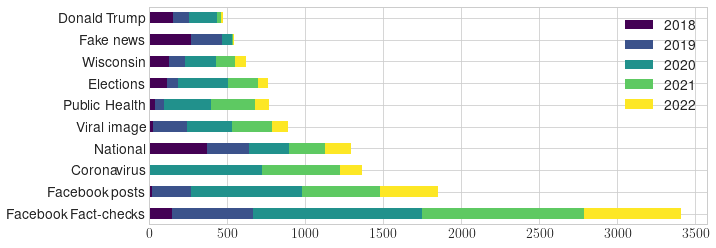

In [ ]:
top_10_tags = tag_df.loc[top_10_tags, :].iloc[:,-5:]

fig1 = top_10_tags.plot(kind='barh', stacked=True, colormap='viridis')
plt.savefig('figs/fig1_top_10_tags.pdf', bbox_inches = "tight")

In [ ]:
# Drop observations with different scale
df_temp = df_temp[~df_temp['meter'].isin(['full-flop', 'half-flip', 'no-flip'])]

cat_by_year = {}

# Extract and count tags used in article by year
for year in df_temp['year'].unique():
    df_new=df_temp[df_temp['year']==year]
    tag_values = pd.Series(df_new['meter']).value_counts()
    cat_by_year[year] = tag_values #Make dictionary: Key = year. Value is count of statement classification (pants-on-fire, false, true etc)
   


cat_by_year = dict(sorted(cat_by_year.items())) #Sort the dict by year

reorder_list = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire'] #define order of sorting to dataframe

df_cat = pd.DataFrame(cat_by_year).fillna(0)
df_cat = df_cat.reindex(reorder_list) #reorder according to above list

In [ ]:
df_cat_dev_cuma = df_cat.iloc[:, :]\
    .cumsum(axis=1)

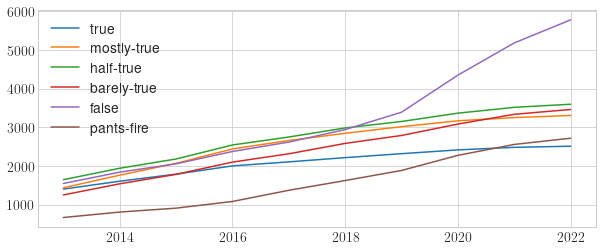

In [ ]:
cat_plot = df_cat_dev_cuma.T.iloc[-10:, :].plot()
plt.savefig('figs/fig2.pdf')

<AxesSubplot:>

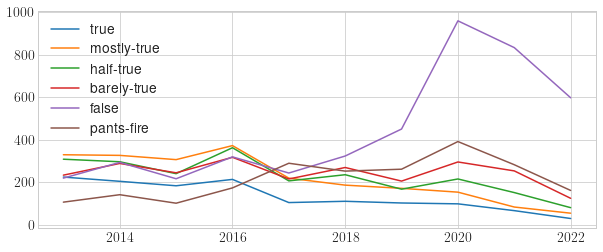

In [ ]:
df_cat.T.iloc[-10:, :].plot()

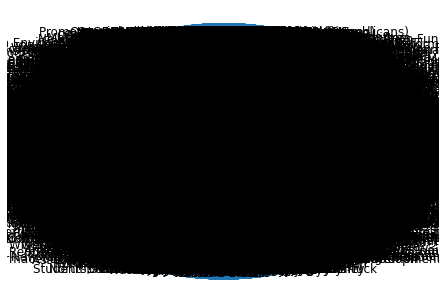

In [101]:
import networkx as nx

G = nx.Graph()
G = nx.from_pandas_edgelist(data, 'meter', 'name_txt')
nx.draw_shell(G, with_labels=True)

In [93]:
data

,quote_href,quote_txt,name_txt,name_href,description_date,description_forum,footer_name,footer_date,meter
0,/factchecks/2022/aug/16/facebook-posts/faceboo...,“Liz Cheney cries like kids after loses in ‘pr...,Facebook posts,/personalities/facebook-posts/,2022-08-14,Facebook post,Andy Nguyen,2022-08-16,pants-fire
1,/factchecks/2022/aug/15/viral-image/monkeypox-...,“They put” monkeypox in the water in Atlanta.,Viral image,/personalities/viral-image/,2022-08-09,Facebook post,Ciara O'Rourke,2022-08-15,false
2,/factchecks/2022/aug/15/viral-image/no-trump-j...,"Donald Trump Jr. tweeted, “While my father lov...",Viral image,/personalities/viral-image/,2022-08-14,Facebook post,Ciara O'Rourke,2022-08-15,false
3,/factchecks/2022/aug/15/tweets/video-showing-r...,Video shows Ron DeSantis arguing with Sean Han...,Tweets,/personalities/tweets/,2022-08-11,tweet,Yacob Reyes,2022-08-15,false
4,/factchecks/2022/aug/15/facebook-posts/bill-ga...,"""Bill Gates and AOC say that a cow emits more ...",Facebook posts,/personalities/facebook-posts/,2022-07-31,Facebook post,Andy Nguyen,2022-08-15,false
...,...,...,...,...,...,...,...,...,...
21647,/factchecks/2007/jun/12/tom-tancredo/most-scie...,"""For every single scientist that tells you (gl...",Tom Tancredo,/personalities/tom-tancredo/,2007-05-15,"Columbia, S.C",Bill Adair,2007-06-12,false
21648,/factchecks/2007/jun/12/john-edwards/economist...,"""We now have the greatest income inequality si...",John Edwards,/personalities/john-edwards/,2007-05-12,story by Reuters wire service,Wes Allison,2007-06-12,true
21649,/factchecks/2007/jun/12/bill-richardson/correc...,"""New Mexico was 46th in teacher pay (when he w...",Bill Richardson,/personalities/bill-richardson/,2007-05-10,TV ad,Bill Adair,2007-06-12,mostly-true
21650,/factchecks/2007/jun/01/tommy-thompson/thompso...,"""Tommy Thompson is the father of welfare refor...",Tommy Thompson,/personalities/tommy-thompson/,2007-05-01,the Web,Lissa August,2007-06-01,true
